# SGD fit tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append("../src")

from stochastic_glv_generator import *
from experiments import *
from analysis import *
from inference import *

In [2]:
n = 3
seed = 123
r_max = 1.
A_diag_std = 1.
A_off_diag_std = 0.1

p = sort_glv_params(n, seed, r_max, A_diag_std, A_off_diag_std)
r = p[:n]
A = p[n:].reshape((n, n))
x_eq = -np.linalg.inv(A)@r
print(x_eq)

env_noise = 0.0
t0 = 0
dt = 1e-2

np.random.seed(123)
init_perturb = np.random.choice([-1., 1.], n)
# init_perturb = -np.ones(n)
init_perturb[init_perturb<0] *= np.random.uniform(0.99, 1., (init_perturb<0).sum())
init_perturb[init_perturb>0] *= np.random.uniform(0.8, 5, (init_perturb>0).sum())
# perturb_scale_list = np.array([0.3, 0.5, 0.8, 1.])
perturb_scale_list = np.random.uniform(0, 1, 1)
t_samp_list = np.linspace(0, 20, 60).reshape((1,-1))
# t_samp_list = np.arange(0, 20+dt, dt)
meas_noise_list = np.array([0.0])
repetitions = 1

replicates = gen_replicates(p, env_noise, init_perturb, perturb_scale_list, t0, dt, t_samp_list, meas_noise_list, repetitions, seed=0, scale_meas_noise_by_abund=True)

[0.27166179 0.41528108 0.35871103]
1/1                                                                                                 

In [3]:
add_time_diff(replicates)
add_log_time_diff(replicates)

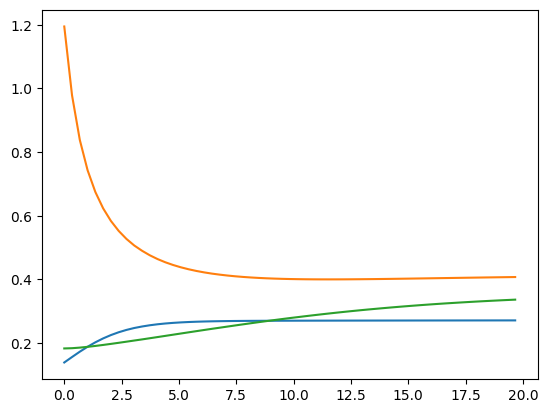

In [7]:
t = replicates.dropna()["time"].values
y = replicates.dropna()[[i for i in replicates.columns if i[:2]=="sp"]].values
dydt = replicates.dropna()[[i for i in replicates.columns if i[:3]=="dsp"]].values

plt.plot(t, y, "-")
plt.show()

In [5]:
alpha = 1e-3
gamma = 0.9
eps = 1e-7
Eg2 = np.zeros_like(p)

mini_batch_sgd_rmsprop(replicates, p, alpha, gamma, eps, Eg2, 1)

(array([ 0.71334498,  0.27854957,  0.25996664, -2.65406432,  0.05953677,
         0.04515678, -0.01386436, -0.86328093,  0.19162348, -0.13018775,
        -0.07737229, -0.35191696]),
 array([1.64628373e-04, 9.86171064e-04, 5.77681325e-05, 6.77273298e-06,
        1.04434932e-04, 6.91549853e-06, 3.29952339e-05, 9.38662426e-04,
        3.68762227e-05, 3.89500246e-06, 1.22771331e-05, 3.88295887e-06]))

0/1000: MSE = 0.0019899044                                                                           

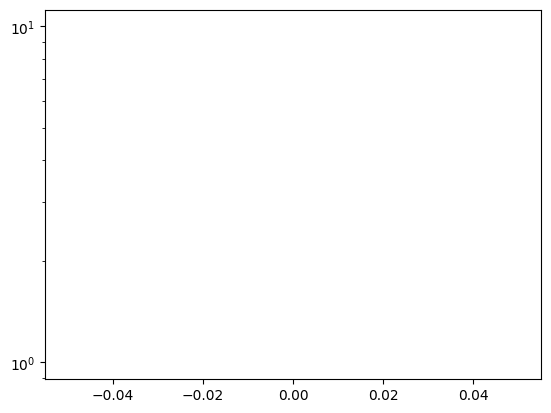

100/1000: MSE = 0.0019539013                                                                         

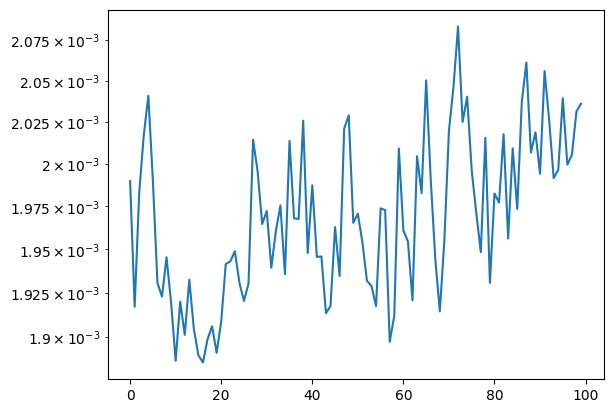

200/1000: MSE = 0.0019926232                                                                         

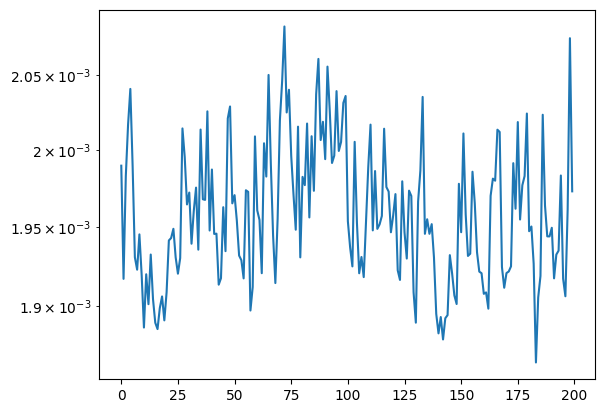

300/1000: MSE = 0.0019995755                                                                         

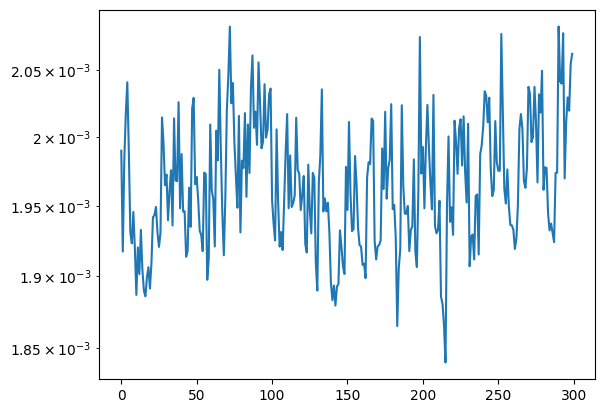

400/1000: MSE = 0.0020094939                                                                         

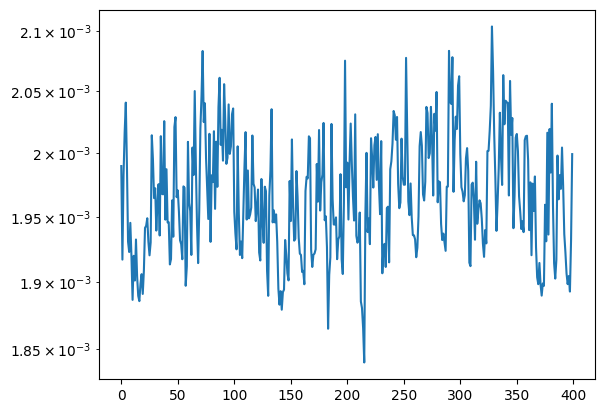

500/1000: MSE = 0.0019275030                                                                         

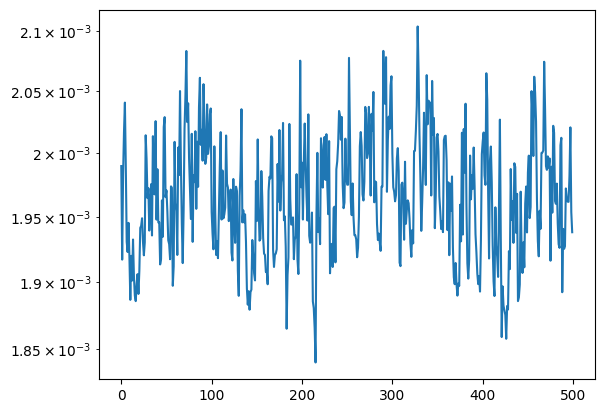

600/1000: MSE = 0.0020150766                                                                         

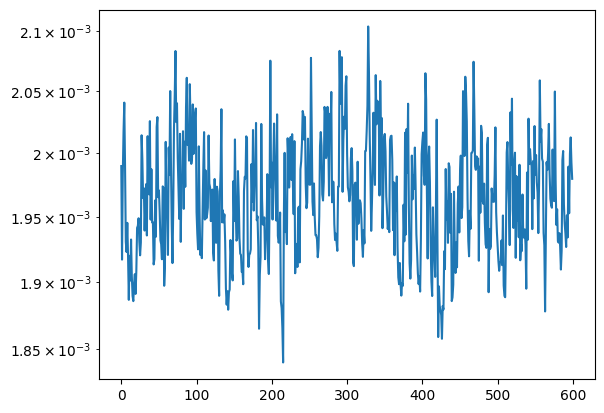

700/1000: MSE = 0.0020495956                                                                         

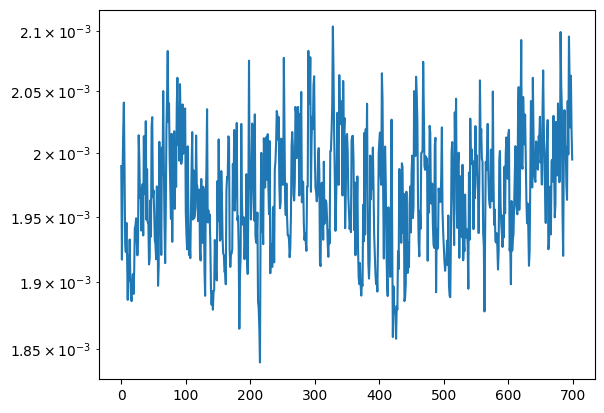

800/1000: MSE = 0.0019332352                                                                         

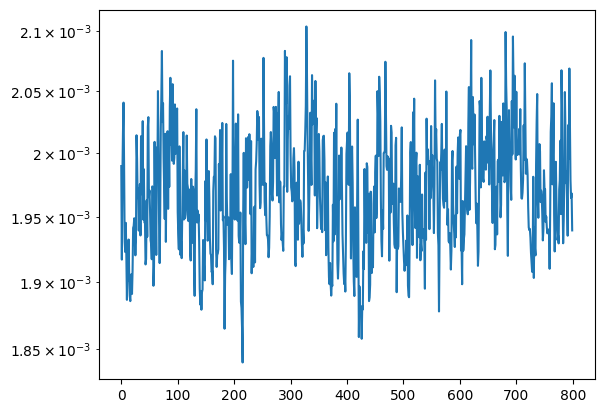

900/1000: MSE = 0.0019791421                                                                         

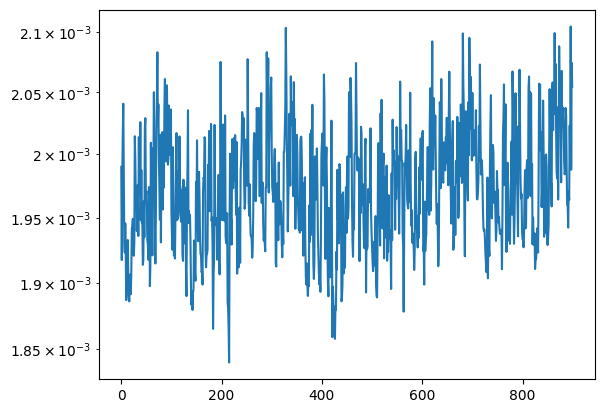

999/1000: MSE = 0.0020218427                                                                         

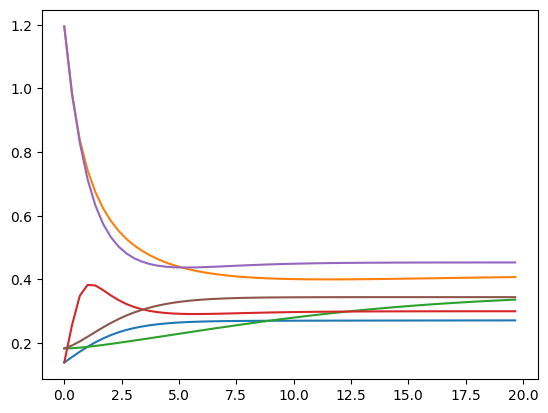

In [10]:
alpha = 1e-3
gamma = 0.9
eps = 1e-7
Eg2 = np.zeros_like(p)

n_steps = 1000
plot_steps = 100

# np.random.seed(1234)
# p2 = np.random.normal(0, 1, n*(n+1))
p2 = p * np.random.normal(1, 0.1, p.shape[0])

p_hist2 = np.zeros((n_steps, p2.shape[0]))
p_hist2[0] = p2

mse_hist = np.zeros(n_steps)

batch_size = 20

for i in range(n_steps):
    
    Eg2 *= 0.
    
    mse_hist[i] = mse(glv_time(t, y, p), dydt)
    
    p2, Eg2 = mini_batch_sgd_rmsprop(replicates, p, alpha, gamma, eps, Eg2, batch_size, averaging="none")
    p_hist2[i] = p2
    
    print("\r", " "*100, end="")
    print("\r"+f"{i}/{n_steps}: MSE = {mse_hist[i]:.10f}", end="")
    
    if i % plot_steps == 0:
        
        plt.plot(mse_hist[:i])
        plt.yscale("log")
        plt.show()
        
sol = euler_maruyama(glv, t[0], y[0], p, 0., dt, t)
        
plt.plot(t, y)
plt.plot(t, sol)